# 2. Data Preparation
📒 `2.0-rc-data-preparation.ipynb`

**Objetivo:** Transformar os dados brutos em um formato para uso em análise exploratória e modelagem.

⚙️ **Atividades:**
- Limpeza dos dados
- Separação dos Dados de Treinamento e Teste
- Tratamento de Variáveis Categóricas
- Normalização/Escalonamento das Variáveis Numéricas
- Tratamento de Desbalanceamento das Classes
- Feature engineering
- Seleção de Features
- Preparação de Pipelines (ColumnTransformer)
- Divisão para Validação (Cross Validation k-fold)
- Salvamento do dataset (`data/processed/`)


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src._utils import detect_outliers_iqr, plot_outliers, handle_outliers, analyze_outliers

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Configura o matplotlib para mostrar gráficos inline
%matplotlib inline

# Setup para mostrar todas as colunas do dataframe
pd.set_option('display.max_columns', None)

In [172]:
# Carrega dados
df = pd.read_csv("../data/raw/bootcamp_train.csv")

print("N° de linhas e colunas: ", df.shape)
df.head()

N° de linhas e colunas:  (35260, 15)


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não


## 1. Limpeza dos Dados

### a) Valores Nulos

In [173]:
# Verifica dados Nulos
df.isnull().sum()

id                                   0
id_produto                           0
tipo                                 0
temperatura_ar                     616
temperatura_processo               599
umidade_relativa                     0
velocidade_rotacional              751
torque                             623
desgaste_da_ferramenta             952
falha_maquina                        0
FDF (Falha Desgaste Ferramenta)      0
FDC (Falha Dissipacao Calor)         0
FP (Falha Potencia)                  0
FTE (Falha Tensao Excessiva)         0
FA (Falha Aleatoria)                 0
dtype: int64

In [174]:
# Tratando Valores Nulos
# Preenchimento de valores ausentes com a mediana ( menos sensivel aos outliers)

num_cols_to_inspect = ['temperatura_ar', 'temperatura_processo', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

for col in num_cols_to_inspect:
    df[col].fillna(df[col].median(), inplace=True)

print("Valores Nulos tratados com a mediana: \n", df.isnull().sum())


Valores Nulos tratados com a mediana: 
 id                                 0
id_produto                         0
tipo                               0
temperatura_ar                     0
temperatura_processo               0
umidade_relativa                   0
velocidade_rotacional              0
torque                             0
desgaste_da_ferramenta             0
falha_maquina                      0
FDF (Falha Desgaste Ferramenta)    0
FDC (Falha Dissipacao Calor)       0
FP (Falha Potencia)                0
FTE (Falha Tensao Excessiva)       0
FA (Falha Aleatoria)               0
dtype: int64


### b) Inconsistência nos dados

In [175]:
# Verifica dados Inconsistentes
print("Descrição dos dados numéricos: \n", df.describe())
print("-"*50)

for col in num_cols_to_inspect:
    print(df.loc[df[col] < 0, col].value_counts())
    print("\n")

Descrição dos dados numéricos: 
                  id  temperatura_ar  temperatura_processo  umidade_relativa  \
count  35260.000000    35260.000000          35260.000000      35260.000000   
mean   17629.500000      270.060479            280.956146         89.997672   
std    10178.829582       95.578134             96.191402          0.142191   
min        0.000000      -36.000000            -38.000000         80.590429   
25%     8814.750000      298.000000            308.500000         90.000000   
50%    17629.500000      299.600000            309.800000         90.000000   
75%    26444.250000      301.000000            310.900000         90.000000   
max    35259.000000      304.500000            313.800000         94.575256   

       velocidade_rotacional        torque  desgaste_da_ferramenta  
count           35260.000000  35260.000000            35260.000000  
mean             1382.383834     40.211941               74.903176  
std               489.033715      8.753262      

In [176]:
# Trata Inconsistências
for col in num_cols_to_inspect:
    df.loc[df[col] < 0, col] = df[col].median()

print("Inconsistências tratadas!")

Inconsistências tratadas!


In [177]:
cols_to_inspect = ['falha_maquina', 'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

# Verifica valores únicos em todas as colunas
for col in cols_to_inspect:
    print(f"Coluna: {col}")
    print(f"Valores únicos: {df[col].unique()}")
    print(f"Quantidade de valores únicos: {df[col].nunique()}")
    print("-"*50)


Coluna: falha_maquina
Valores únicos: ['não' 'Não' 'sim' 'N' '0' 'Sim' 'y' '1']
Quantidade de valores únicos: 8
--------------------------------------------------
Coluna: FDF (Falha Desgaste Ferramenta)
Valores únicos: ['False' 'N' '0' 'True' '-' '1']
Quantidade de valores únicos: 6
--------------------------------------------------
Coluna: FDC (Falha Dissipacao Calor)
Valores únicos: ['False' 'nao' '0' 'True' 'y' '1']
Quantidade de valores únicos: 6
--------------------------------------------------
Coluna: FP (Falha Potencia)
Valores únicos: ['Não' 'não' 'Sim' 'N' '0' 'sim' '1' 'y']
Quantidade de valores únicos: 8
--------------------------------------------------
Coluna: FTE (Falha Tensao Excessiva)
Valores únicos: [False  True]
Quantidade de valores únicos: 2
--------------------------------------------------
Coluna: FA (Falha Aleatoria)
Valores únicos: ['Não' 'não' '0' '-' 'Sim' 'sim' '1']
Quantidade de valores únicos: 7
--------------------------------------------------


In [178]:
# Dicionário de mapeamento para padronizar valores binários
map_classes = {
    # Valores que representam "0" (não/falso)
    'não': '0',
    'Não': '0',
    'N': '0',
    'False': '0',
    'false': '0',
    'nao': '0',
    '-': '0',
    # Valores que representam "1" (sim/verdadeiro)
    'sim': '1',
    'Sim': '1',
    'y': '1',
    'True': '1',
    'true': '1'
}

# Lista de colunas para aplicar a transformação
cols_to_transform = [
    'falha_maquina',
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)'
]

# Aplica a transformação em cada coluna
for col in cols_to_transform:
    # Converte booleanos para string antes do mapeamento
    df[col] = df[col].astype(str)
    # Aplica o mapeamento
    df[col] = df[col].map(lambda x: map_classes.get(x, x))
    # Converte a coluna para tipo numérico
    df[col] = pd.to_numeric(df[col])

# Verifica os valores únicos após a transformação
print("Verificação após a transformação:")
print("-" * 50)
for col in cols_to_transform:
    print(f"Coluna: {col}")
    print(f"Valores únicos: {df[col].unique()}")
    print(f"Quantidade: {df[col].nunique()}")
    print("-" * 50)



Verificação após a transformação:
--------------------------------------------------
Coluna: falha_maquina
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: FDF (Falha Desgaste Ferramenta)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: FDC (Falha Dissipacao Calor)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: FP (Falha Potencia)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: FTE (Falha Tensao Excessiva)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: FA (Falha Aleatoria)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------


### c) Dados Duplicados

In [179]:
print("Dados Duplicados:", df.duplicated().sum())

Dados Duplicados: 0


### d) Análise de Outliers

Linhas originais: 35260
Linhas removidas (outliers): 2024
Linhas após limpeza: 33236
                column  n_outliers  percentage_outliers  lower_bound  upper_bound
        temperatura_ar           0             0.000000       294.75       304.75
  temperatura_processo           8             0.022689       305.90       313.90
      umidade_relativa          35             0.099263        90.00        90.00
 velocidade_rotacional        1811             5.136132      1236.00      1772.00
                torque         371             1.052184        17.10        63.50
desgaste_da_ferramenta           0             0.000000       -86.00       298.00


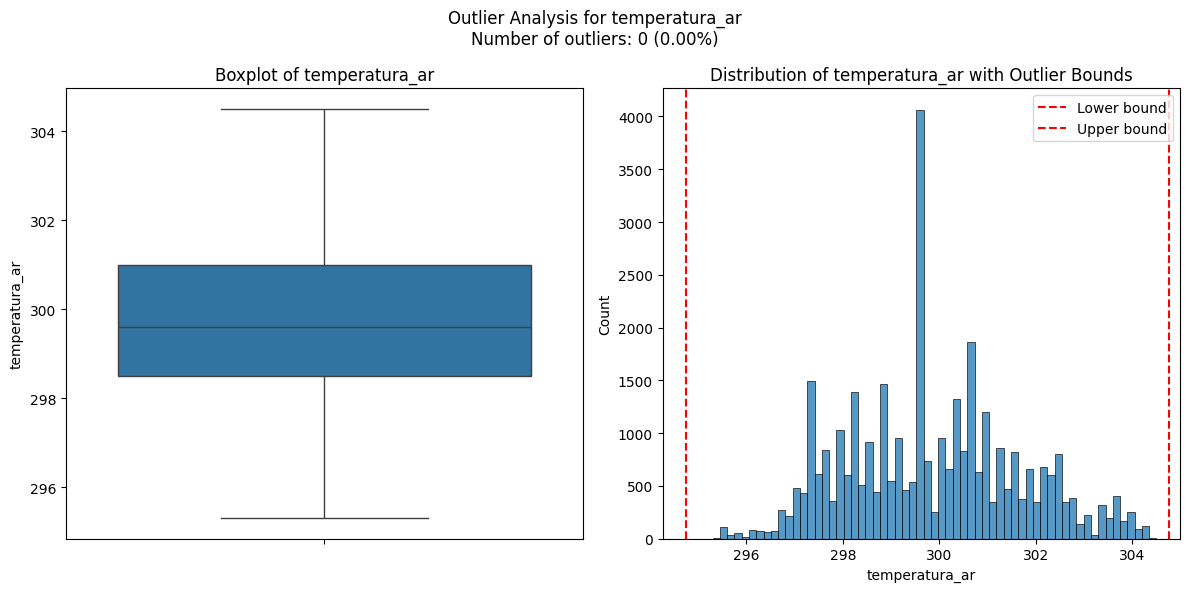

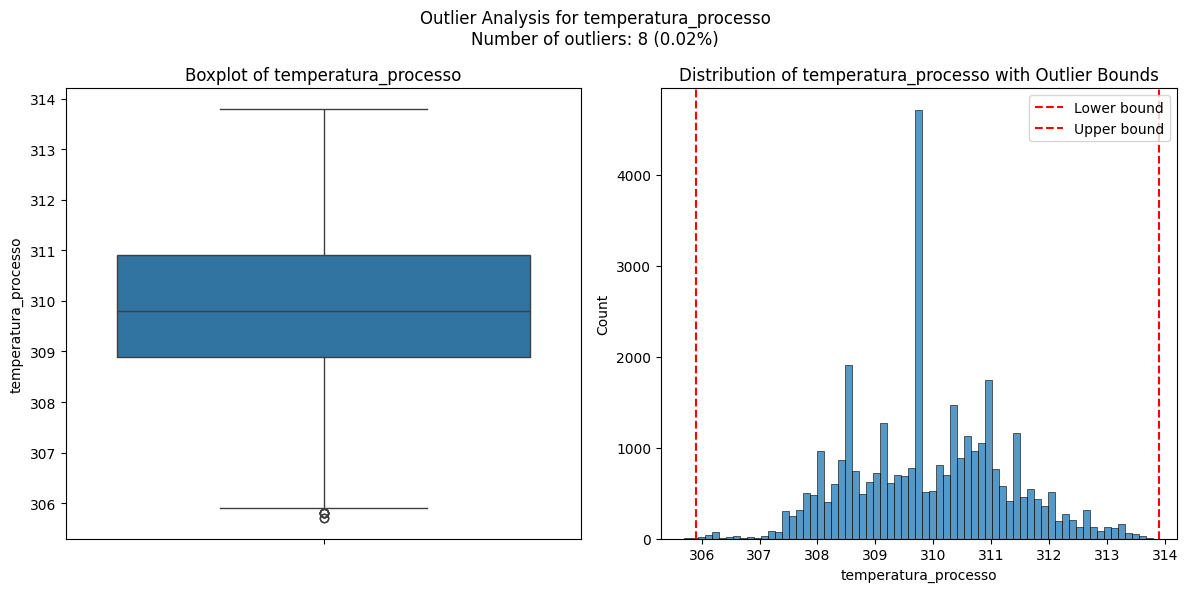

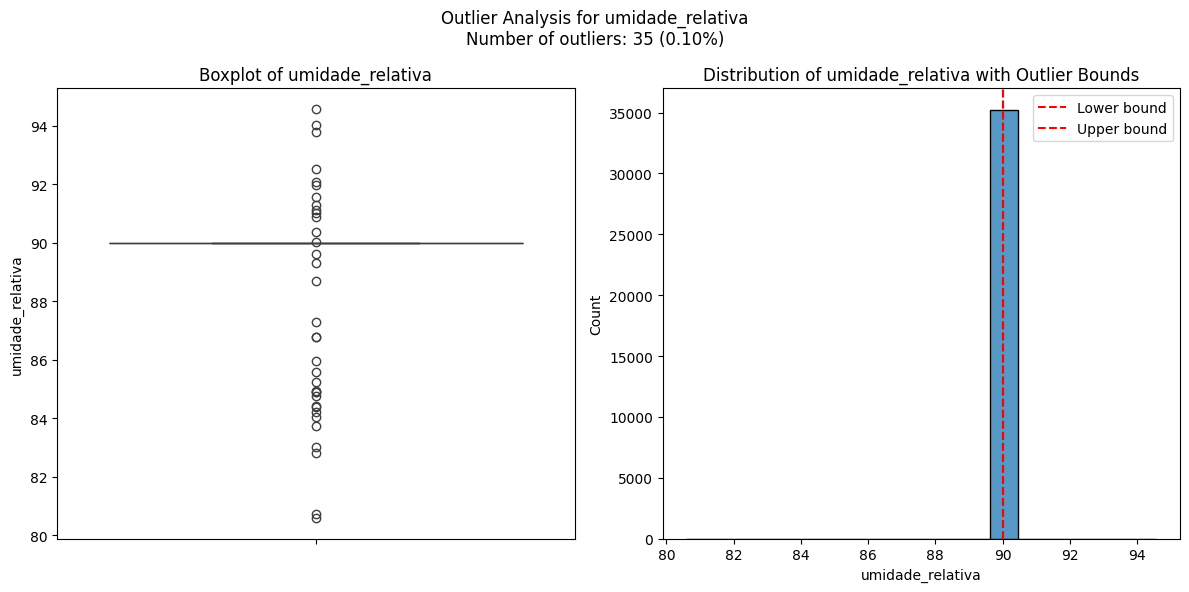

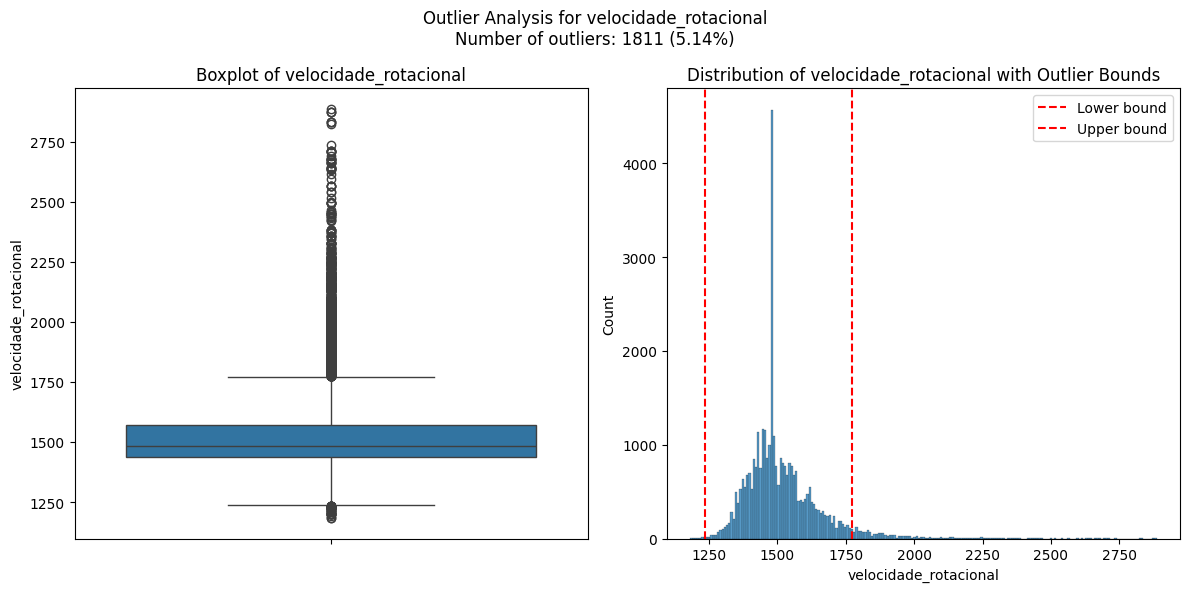

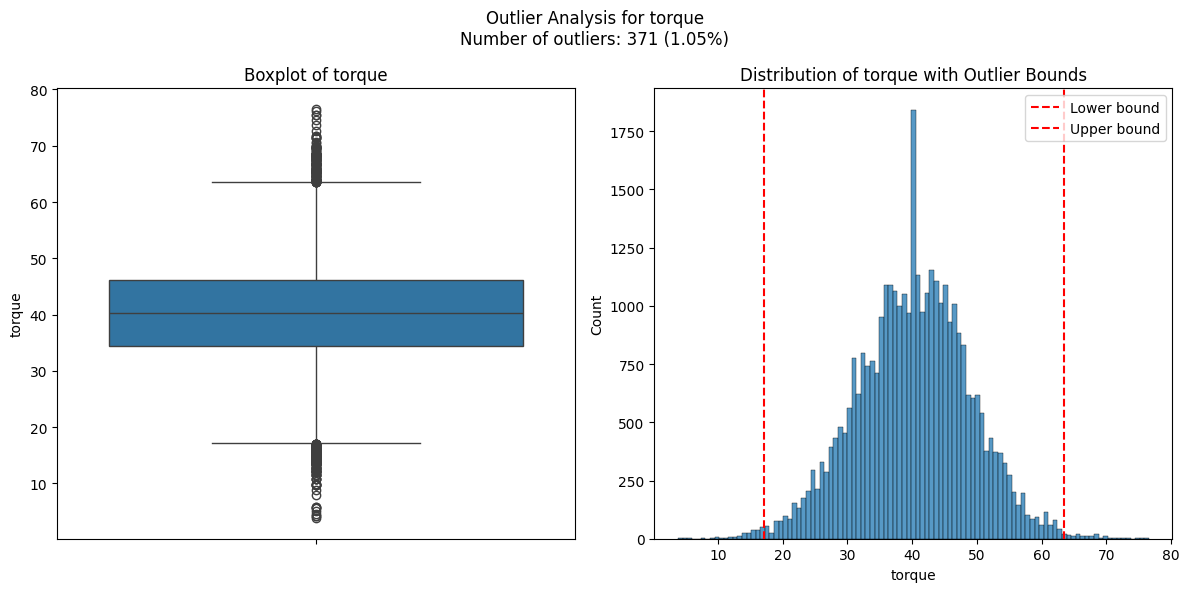

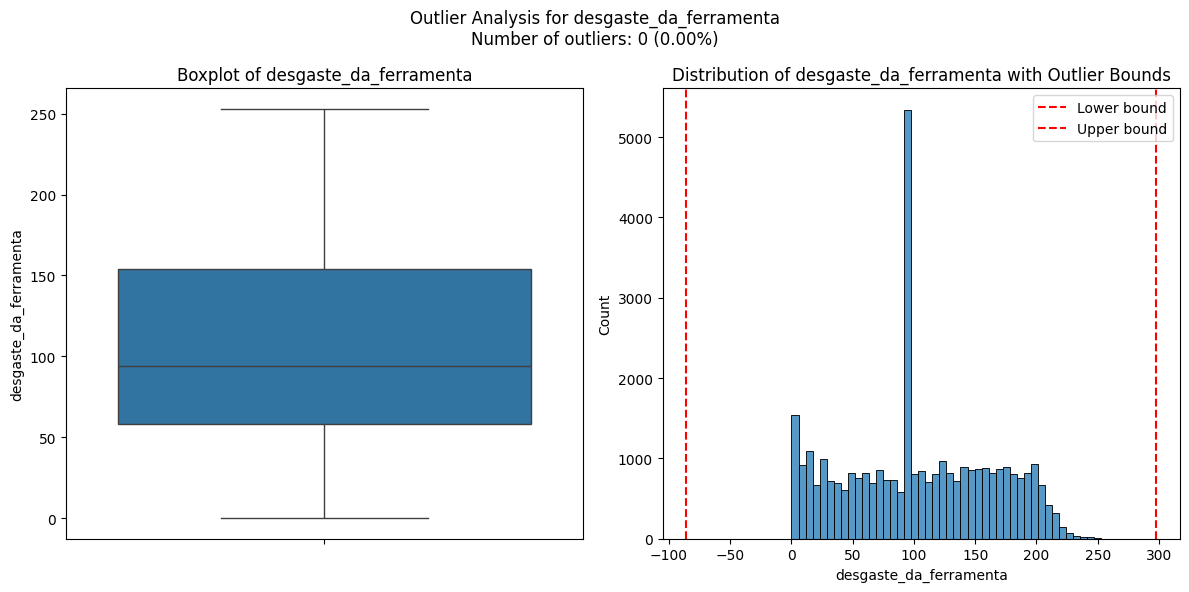

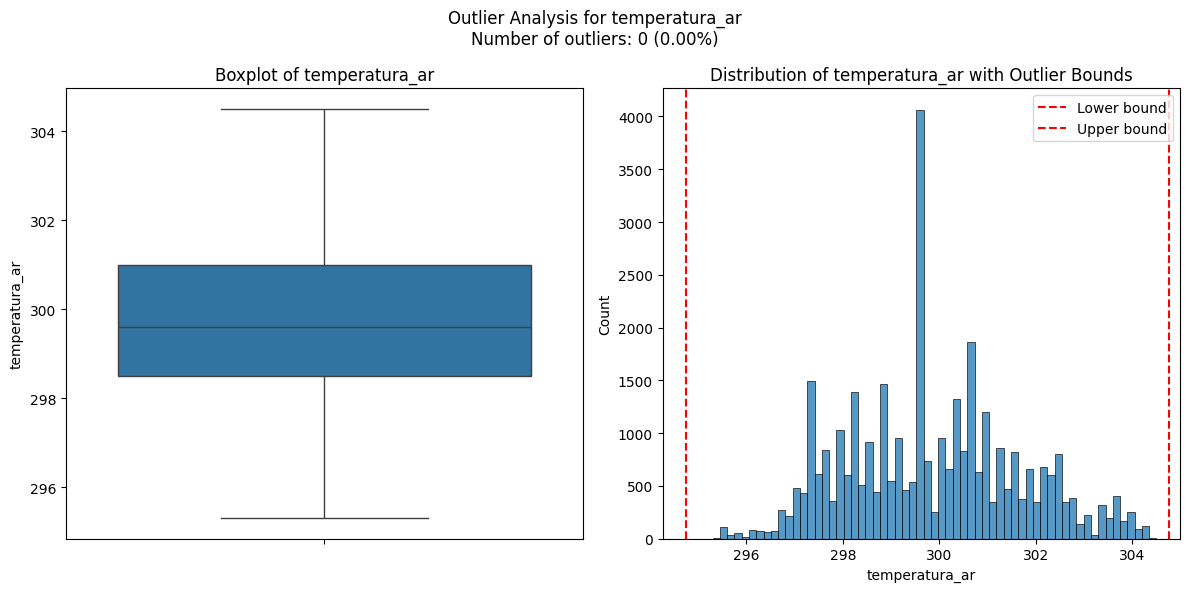

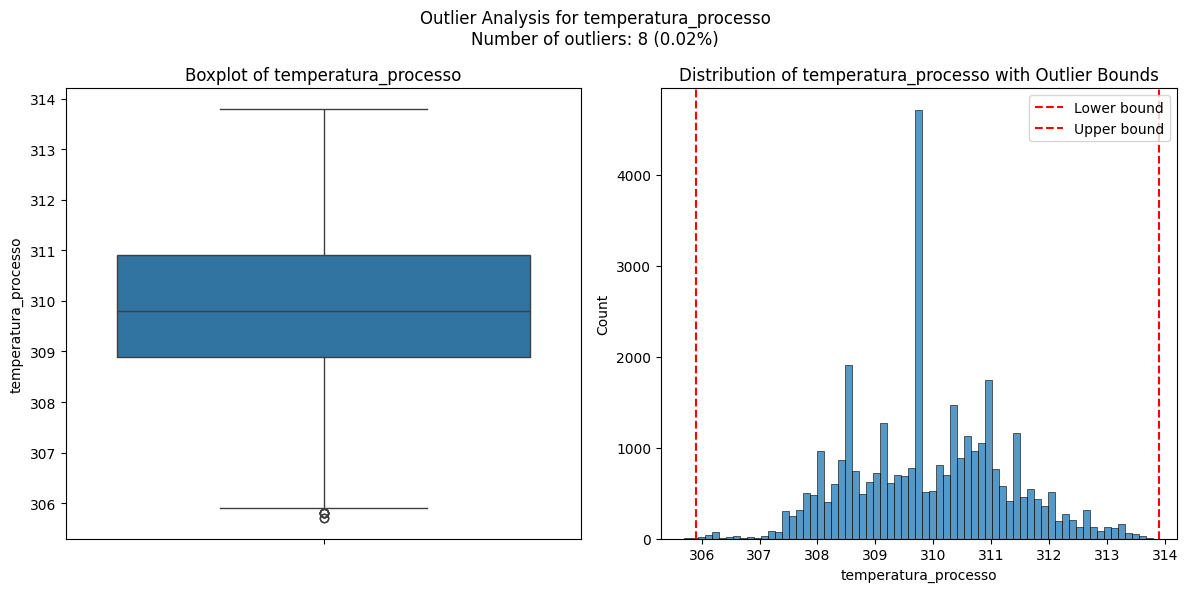

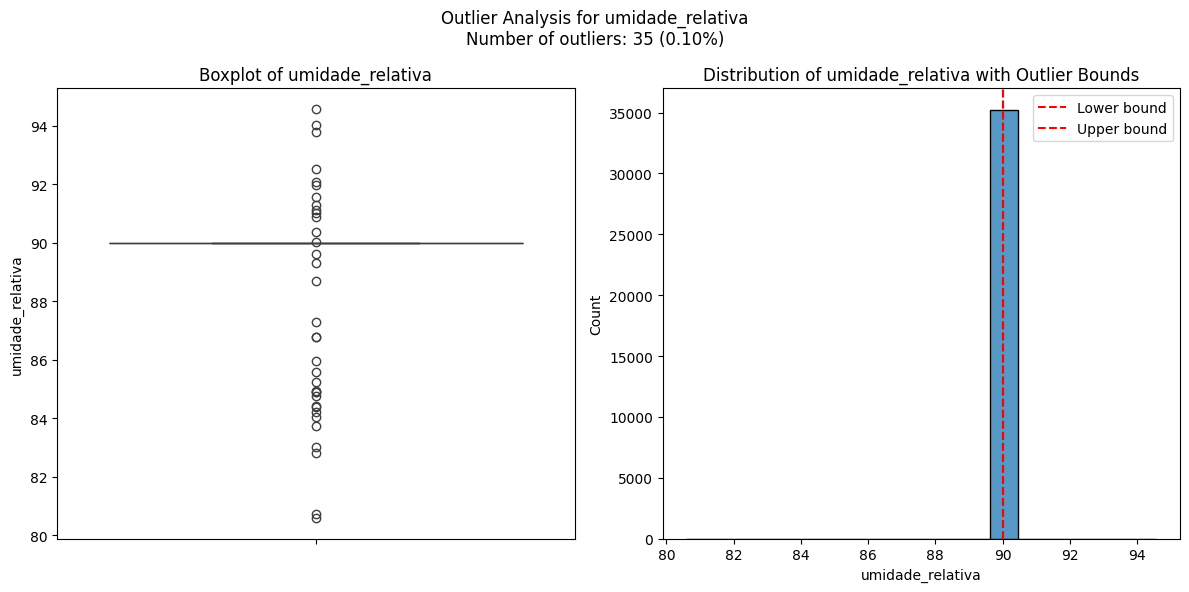

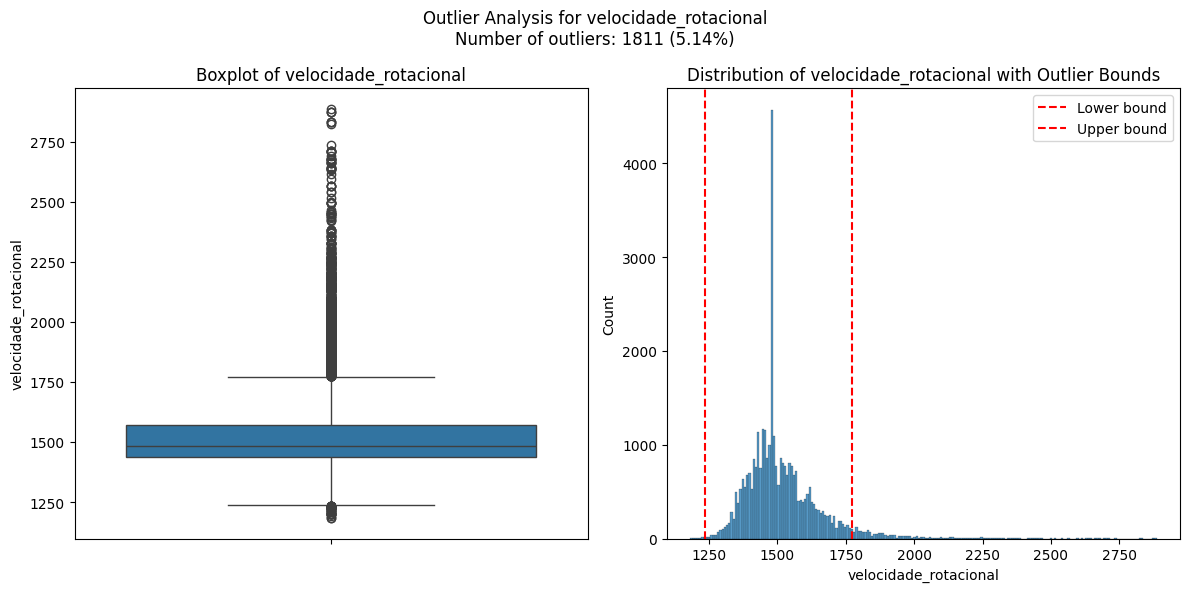

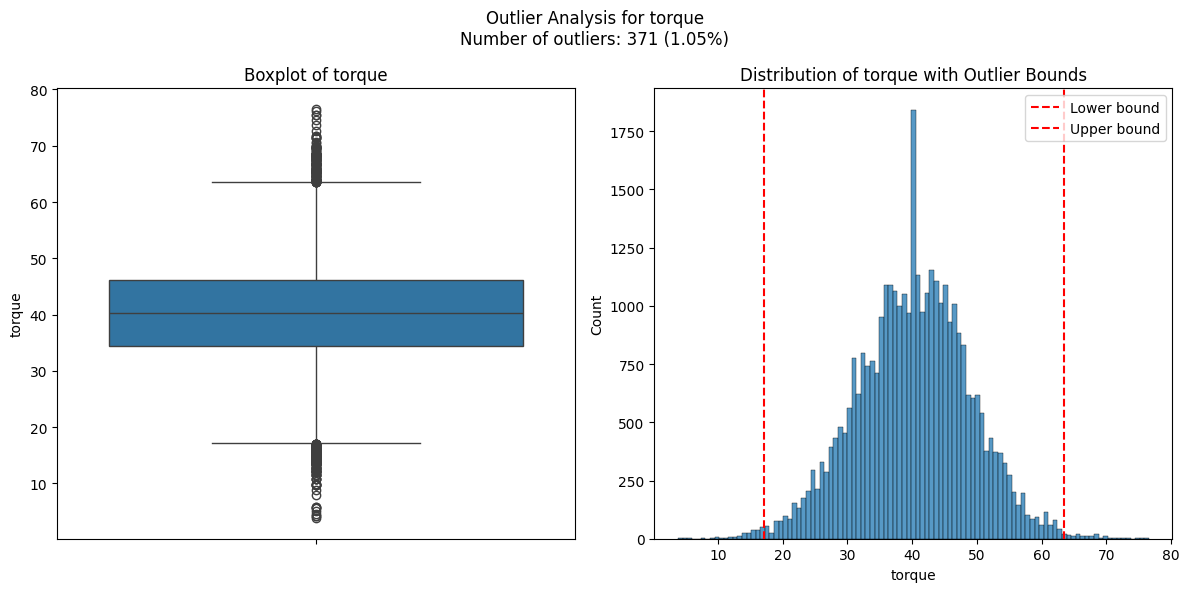

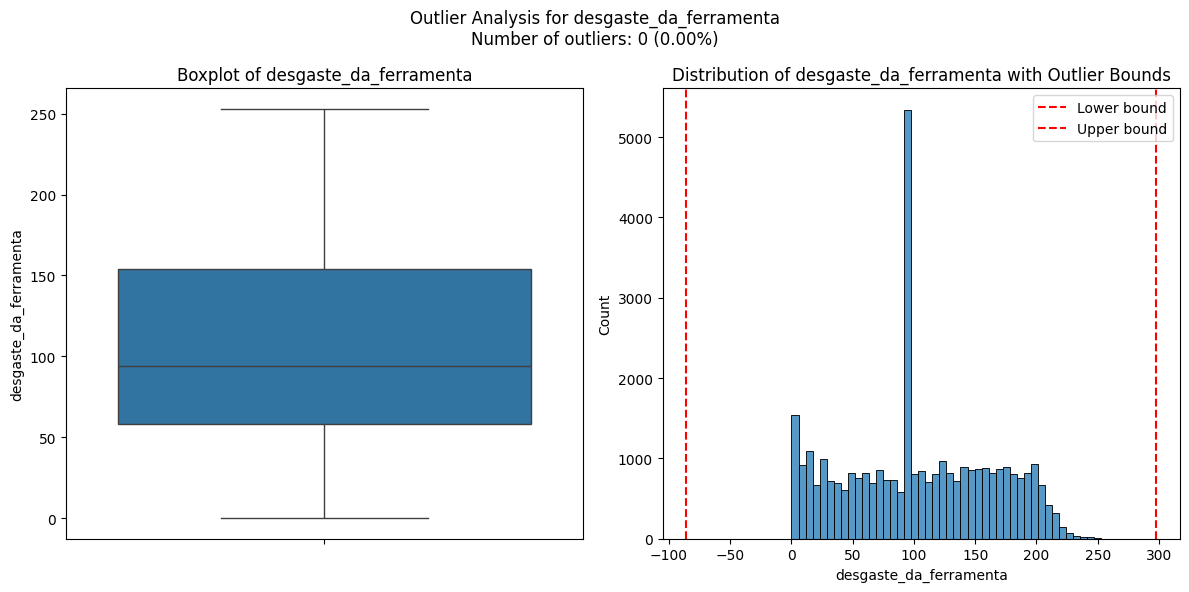

In [180]:
numeric_cols = [
    'temperatura_ar','temperatura_processo','umidade_relativa',
    'velocidade_rotacional','torque','desgaste_da_ferramenta'
]

# máscara acumulada de "é outlier em QUALQUER coluna"
any_outlier = pd.Series(False, index=df.index)

for col in numeric_cols:
    mask, stats = detect_outliers_iqr(df[col], col)
    plot_outliers(df[col], col, mask, stats)
    any_outlier |= mask  # acumula outliers

# remover linhas que são outlier em qualquer coluna
df_clean = df.loc[~any_outlier].copy()

print(f"Linhas originais: {len(df)}")
print(f"Linhas removidas (outliers): {any_outlier.sum()}")
print(f"Linhas após limpeza: {len(df_clean)}")

# Análise resumida
outlier_analysis = analyze_outliers(df, numeric_cols) 
print(outlier_analysis.to_string(index=False))


In [181]:
# Renomeia as colunas
cols_rename = {
    'id': 'id',
    'id_produto': 'id_produto',
    'tipo': 'tipo',
    'temperatura_ar': 'temperatura_ar_[K]',
    'temperatura_processo': 'temperatura_processo_[K]',
    'umidade_relativa': 'umidade_relativa_[%]',
    'velocidade_rotacional': 'velocidade_rotacional_[rpm]',
    'torque': 'torque_[Nm]',
    'desgaste_da_ferramenta': 'desgaste_da_ferramenta_[mm]',
    'falha_maquina': 'falha_maquina',
    'FTE (Falha Tensao Excessiva)': 'FTE',
    'FDC (Falha Dissipacao Calor)': 'FDC',
    'FP (Falha Potencia)': 'FP',
    'FDF (Falha Desgaste Ferramenta)': 'FDF',
    'FA (Falha Aleatoria)': 'FA'
}

df_clean.rename(columns=cols_rename, inplace=True)

# Informações sobre as colunas
df_clean.info()

# Visualiza as 5 primeiras linhas
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 33236 entries, 0 to 35259
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           33236 non-null  int64  
 1   id_produto                   33236 non-null  object 
 2   tipo                         33236 non-null  object 
 3   temperatura_ar_[K]           33236 non-null  float64
 4   temperatura_processo_[K]     33236 non-null  float64
 5   umidade_relativa_[%]         33236 non-null  float64
 6   velocidade_rotacional_[rpm]  33236 non-null  float64
 7   torque_[Nm]                  33236 non-null  float64
 8   desgaste_da_ferramenta_[mm]  33236 non-null  float64
 9   falha_maquina                33236 non-null  int64  
 10  FDF                          33236 non-null  int64  
 11  FDC                          33236 non-null  int64  
 12  FP                           33236 non-null  int64  
 13  FTE                  

,id,id_produto,tipo,temperatura_ar_[K],temperatura_processo_[K],umidade_relativa_[%],velocidade_rotacional_[rpm],torque_[Nm],desgaste_da_ferramenta_[mm],falha_maquina,FDF,FDC,FP,FTE,FA
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,0,0,0,0,0,0
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,0,0,0,0,0,0
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,94.0,0,0,0,0,0,0
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,0,0,0,0,0,0
4,4,L53849,L,299.6,310.5,90.0,1571.0,33.9,94.0,0,0,0,0,0,0


In [182]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33236 entries, 0 to 35259
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           33236 non-null  int64  
 1   id_produto                   33236 non-null  object 
 2   tipo                         33236 non-null  object 
 3   temperatura_ar_[K]           33236 non-null  float64
 4   temperatura_processo_[K]     33236 non-null  float64
 5   umidade_relativa_[%]         33236 non-null  float64
 6   velocidade_rotacional_[rpm]  33236 non-null  float64
 7   torque_[Nm]                  33236 non-null  float64
 8   desgaste_da_ferramenta_[mm]  33236 non-null  float64
 9   falha_maquina                33236 non-null  int64  
 10  FDF                          33236 non-null  int64  
 11  FDC                          33236 non-null  int64  
 12  FP                           33236 non-null  int64  
 13  FTE                  

### Visualiza os Dados com Pandas Profile Report

In [198]:
# Visualiza os dados pós tratamento com Pandas Profiling
from ydata_profiling import ProfileReport

FILE_PATH = "../reports/profile-reports/data_cleaned.html"

profile = ProfileReport(
    df_clean,
    title="Profiling Report - Dados Tratados"
)

# Salva HTML estático
profile.to_file(FILE_PATH)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 116.28it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [184]:
# Salva o dataset tratado
path_to_save = "../data/processed/data_cleaned.csv"
df_clean.to_csv(path_to_save, index=False)

## 2. Pré Processamento

In [208]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import json

 #sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate # Divisão de dados
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler # Transformações de pré-processamento
from sklearn.compose import ColumnTransformer # Combina transformações de pré-processamento
from sklearn.pipeline import Pipeline # Pipeline de pré-processamento

from joblib import dump

# Configuração
RANDOM_SEED = 42



In [209]:
# Carrega o dataset tratado
df = pd.read_csv('../data/processed/data_cleaned.csv')

# Remove as colunas id e id_produto
df.drop(columns=['id','id_produto'],inplace=True)

df.head()

,tipo,temperatura_ar_[K],temperatura_processo_[K],umidade_relativa_[%],velocidade_rotacional_[rpm],torque_[Nm],desgaste_da_ferramenta_[mm],falha_maquina,FDF,FDC,FP,FTE,FA
0,L,298.3,309.1,90.0,1616.0,31.1,195.0,0,0,0,0,0,0
1,L,298.2,308.4,90.0,1388.0,53.8,137.0,0,0,0,0,0,0
2,L,298.2,307.8,90.0,1528.0,31.1,94.0,0,0,0,0,0,0
3,M,300.9,310.8,90.0,1599.0,33.0,7.0,0,0,0,0,0,0
4,L,299.6,310.5,90.0,1571.0,33.9,94.0,0,0,0,0,0,0


In [ ]:
# Variáveis Alvo (Y)
target_vars = ['falha_maquina', 
               'FTE', 
               'FDC', 
               'FP', 
               'FDF', 
               'FA']

# Seleciona os atributos numéricos e categóricos (X) e a variável alvo (y)
X = df.drop(columns=target_vars).copy()
y = df['falha_maquina'].copy()

# # Identifica e seleciona os atributos numéricos e categóricos
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categoric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Pré-processamento em Pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categoric_cols) # Ignora valores desconhecidos
],
    remainder='drop' # Deleta as colunas que não foram transformadas
)

print(f"Variável Alvo (y): {y.name}")
print(f"\nAtributos Numéricos (X): {numeric_cols}")
print(f"\nAtributos Categóricas (X): {categoric_cols}")


Variável Alvo (y): falha_maquina

Atributos Numéricos (X): ['temperatura_ar_[K]', 'temperatura_processo_[K]', 'umidade_relativa_[%]', 'velocidade_rotacional_[rpm]', 'torque_[Nm]', 'desgaste_da_ferramenta_[mm]']

Atributos Categóricas (X): ['tipo']


### Salva os artefatos e dados tratados 

In [212]:

# Persistência dos dados tratados
os.makedirs('../models/artifacts', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Salvar os splits para manter os dados tratados
X_train.to_csv('../data/interim/X_train.csv', index=False)
X_test.to_csv('../data/interim/X_test.csv', index=False)
y_train.to_csv('../data/interim/y_train.csv', index=False)
y_test.to_csv('../data/interim/y_test.csv', index=False)


# Salvar “especificação” do pré-processamento (listas de colunas + objeto definidos/ sem ajuste)
dump({
    "numeric_cols": numeric_cols,
    "categorical_cols": categoric_cols,
    "preprocessor": preprocessor,
    "random_seed": RANDOM_SEED,
    "target_name": "falha_maquina",
    "target_vars_all": target_vars
}, "../models/artifacts/preprocessing_spec.joblib")

['../models/artifacts/preprocessing_spec.joblib']